In [1]:
import sys
import pathlib
sys.path.append(str(pathlib.PurePath(pathlib.Path.cwd().parent)))

import numpy as np
import matplotlib.cm as cm
import matplotlib.axes as am
import matplotlib.pyplot as plt
%matplotlib widget

import dimod
import dwave
import dwave.system
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
import dwave.inspector
import dwave_networkx as dnx
import minorminer

from src.particle_funcs import distance_matrix as distance_matrix
from src.particle_funcs import io as particles_io
import src.leap_funcs.qubo.q_matrix as q_matrix

from src import leap_funcs as leap_funcs
from src.leap_funcs import embedding_quality
from src.leap_funcs.qubo import parameterstudy

from src import h5py_funcs
from src.h5py_funcs import inspections, discoveries, init_custom_getstates, io, parameterstudy_using_info_file

Custom getstate functions for dwave.cloud.config.models.ClientConfig, dwave.cloud.client.qpu.Client, dwave.cloud.solver.StructuredSolver, dwave.system.samplers.dwave_sampler.DWaveSampler, dwave.system.composites.embedding.FixedEmbeddingComposite have been initialized.


In [2]:
study_name = 'sub_2'
info_file_name = r'study_params_small.h5'
study_name = 'sub_3'
info_file_name = r'study_params_sub3.h5'

study_folder_path = pathlib.Path.cwd().joinpath('01_out\\'+study_name)

info_file_name_path = pathlib.Path.joinpath(study_folder_path, info_file_name)
samples_folder_name = r'samples'
samples_folder_name_path = pathlib.Path.joinpath(study_folder_path, samples_folder_name)
print(str(info_file_name_path)[-3:])
assert info_file_name_path.exists(), f'Info file does not exist. Check info_file_name_path ({info_file_name_path})'

.h5


In [3]:
dict_info_read = h5py_funcs.inspections.read_info_file_to_dict(info_file_name_path=info_file_name_path, infoset_name = 'info')
dict_info_read.keys()

dict_keys(['attrs', 'DEMs', 'nearest_neighbours', 'qubos', 'embs_files', 'study', 'time_history'])

In [4]:
print(dict_info_read['study'])
study_read = dict_info_read['study']['data']
study_read.dtype.names
est_runts = study_read['sets']['estimated_runtime']
cum_est_runts = np.sum(est_runts)
print(est_runts)
print('cummulative estimated runtime for 1000 samples each is [h]:', cum_est_runts/3600)
del study_read, est_runts, cum_est_runts


{'attrs': {}, 'data': array([((453.16081486,  979.03419752, 2776.63309127, 3.36475448), b'zz_0594500236'),
       ((442.39189413,  979.03419752, 2776.63309127, 3.35398556), b'zz_8399935511'),
       ((453.16081486, 3440.09693246, 2776.63309127, 3.36721555), b'zz_8254472835'),
       ((453.16081486,  979.03419752,  588.32992986, 1.17645132), b'zz_5764679840'),
       ((453.16081486, 3440.09693246,  588.32992986, 1.17891239), b'zz_0210405625'),
       ((442.39189413,  979.03419752,  588.32992986, 1.1656824 ), b'zz_9579793783'),
       ((442.39189413, 3440.09693246, 2776.63309127, 3.35644663), b'zz_9568089288'),
       ((442.39189413, 3440.09693246,  588.32992986, 1.16814347), b'zz_0562826232'),
       ((518.32459855, 4388.81576527, 1384.37397406, 2.04106893), b'zz_0922653251'),
       ((960.72866133, 4388.81576527, 1384.37397406, 2.483473  ), b'zz_2434077918'),
       ((518.32459855, 1326.67769212, 1384.37397406, 2.03800679), b'zz_2871450148'),
       ((518.32459855, 4388.81576527, 3023.

In [5]:
array_identifiers, started_psets, finished_psets = h5py_funcs.inspections.extract_identifiers(dict_info_read = dict_info_read)

print(started_psets)
print(finished_psets)
print('{p1}/{p2} p_sets have been started, \n {p3}/{p2} p_sets have been finished'.format(p1=len(started_psets), p2=array_identifiers.shape[0], p3=len(finished_psets)))


[b'zz_0594500236', b'zz_8399935511', b'zz_8254472835', b'zz_5764679840', b'zz_0210405625', b'zz_9579793783', b'zz_9568089288', b'zz_0562826232', b'zz_0922653251', b'zz_2434077918', b'zz_2871450148', b'zz_8798000343', b'zz_9357211953', b'zz_6580697660', b'zz_6408592024', b'zz_8383268435', b'zz_0497928876', b'zz_6726194657', b'zz_6629375788', b'zz_4041835465', b'zz_9144036899', b'zz_7631550656', b'zz_2038950416', b'zz_1161068603', b'zz_7253153800', b'zz_2927355622', b'zz_6809108860', b'zz_1638988001', b'zz_8677621521', b'zz_1426986117', b'zz_6519846298', b'zz_6753648971', b'zz_7113932168', b'zz_8093166368', b'zz_3595284705', b'zz_8115207891', b'zz_7406910559', b'zz_0470282487', b'zz_6072268519', b'zz_2751579513', b'zz_6267210246', b'zz_9120108892', b'zz_9283105305', b'zz_6570843060', b'zz_3740505924', b'zz_0859115108', b'zz_9068195746', b'zz_5986609357', b'zz_2282652989', b'zz_4724076768', b'zz_6684243645', b'zz_0760343573', b'zz_6688397866', b'zz_1357332004', b'zz_6262717099', b'zz_4561

In [6]:
dict_for_df = h5py_funcs.inspections.read_answers_to_dict(\
    samples_folder_name_path=samples_folder_name_path\
    , array_identifiers=array_identifiers[:])
print(dict_for_df.__sizeof__()) # size in memory in bytes
print(len(dict_for_df)) # number of keys in dict


512/512 file zz_3380342439.h5 in dir: Truee
13040
394


In [7]:
#pd.DataFrame.from_dict(dict_for_df) # doesnt seem too helpful

In [8]:
import ast
import dwave.samplers

num_particles = 5
qubo = dict_info_read['qubos'][f'{num_particles}_{num_particles}']

#sim_annealing_sample = dimod.samplers.ExactSolver().sample_qubo(
#    {ast.literal_eval(key): value['data'] for key, value in qubo.items()})
sim_annealing_sample = dwave.samplers.SimulatedAnnealingSampler().sample_qubo(
    {ast.literal_eval(key): value['data'] for key, value in qubo.items()},
    num_reads=1000)
sim_annealing_sample = sim_annealing_sample.aggregate() # accumulates number of occurences

In [9]:
type(sim_annealing_sample)

dimod.sampleset.SampleSet

In [10]:
exact_sol = sim_annealing_sample.record
exact_sol.sort(order='energy')
exact_sol

rec.array([([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], -9.90205303, 14),
           ([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], -9.89043746, 13),
           ([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], -9.88628398,  9),
           ([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], -9.88406401, 12),
           ([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], -9.88305524, 10),
           ([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0], -9.88083528,  8),
           ([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0], -9.88065613, 11),
           ([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], -9.87897741,  8),
           ([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], -9.87143967,  8),
           ([1, 0, 0, 0, 0, 0, 1, 0, 

In [51]:
n_samples_to_compare = 5
n_exact_sols_to_compare = 3
colour_label = 'fraction_samples_matched_5_samps_3_sols'
#colour_label = 'fraction_samples_is_found_best'
dir_name_path_plots = './01_out/'
training_iterations = 50

In [52]:
success_dict = h5py_funcs.inspections.extract_success_dict(\
    dict_for_df = dict_for_df\
    , exact_sols = exact_sol\
    , n_samples_to_compare = n_samples_to_compare\
    , n_exact_sols_to_compare = n_exact_sols_to_compare)


for key in success_dict.keys():
    print(key, success_dict[key])

zz_5779935013 {'is_found_best': True, 'num_runs_is_found_best': 10, 'num_samples_is_found_best': 104, 'num_samples_is_found_best_per_run': [18, 6, 10, 10, 6, 8, 7, 14, 16, 9], 'is_found_best_per_run': [True, True, True, True, True, True, True, True, True, True], 'num_samples': 10000, 'num_runs': 10, 'num_subs_per_run': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'num_samples_per_run': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'num_samples_per_sub_per_run': [[500, 500], [500, 500], [500, 500], [500, 500], [500, 500], [500, 500], [500, 500], [500, 500], [500, 500], [500, 500]], 'num_matched': 58, 'num_matched_per_run': [6, 6, 6, 6, 5, 6, 6, 6, 6, 5], 'num_matched_per_sub_per_run': [[3, 3], [3, 3], [3, 3], [3, 3], [2, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 2]], 'num_samples_matched': 285, 'num_samples_matched_per_run': [29, 21, 35, 22, 21, 29, 26, 39, 46, 17], 'num_samples_matched_per_sub_per_run': [[15, 14], [14, 7], [23, 12], [9, 13], [7, 14], [13, 16], [11, 15], [31, 8], [21, 

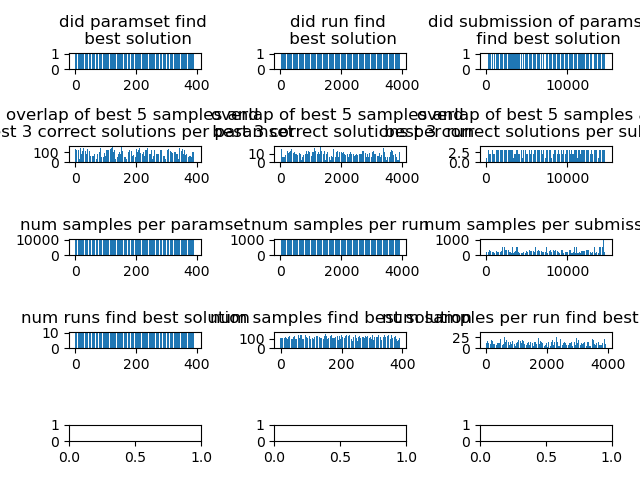

In [53]:
fig = h5py_funcs.inspections.return_bar_plot(\
    success_dict = success_dict\
    , n_samples_to_compare = n_samples_to_compare\
    , n_exact_sols_to_compare = n_exact_sols_to_compare)



In [54]:
a = np.zeros((dict_info_read['study']['data'].shape[0],))
print(a)
print(dict_info_read['study']['data']['sets'].shape)
print(dict_info_read['study']['data']['sets'].dtype.isalignedstruct)
b = np.lib.recfunctions.rec_append_fields(dict_info_read['study']['data'], 'param 1', a)
print(b)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [55]:
print(b.dtype)

(numpy.record, [('sets', [('annealing_time', '<f8'), ('programming_thermalization', '<f8'), ('readout_thermalization', '<f8'), ('estimated_runtime', '<f8')]), ('identifiers', 'S13'), ('param 1', '<f8')])


In [56]:
dict_info_read['study']['data']['sets'].copy().view(dtype=np.float64, type=np.ndarray)

array([4.53160815e+02, 9.79034198e+02, 2.77663309e+03, ...,
       3.29688527e+02, 3.52739416e+02, 7.00308507e-01])

In [57]:
started_sets, study_matched_started_ids = h5py_funcs.inspections.extract_started_sets_from_success_dict(\
    success_dict = success_dict\
    , dict_info_read = dict_info_read)
print(started_sets)
print(study_matched_started_ids)
print(study_matched_started_ids.dtype)

[b'zz_5779935013', b'zz_0594500236', b'zz_0841745074', b'zz_8399935511', b'zz_8254472835', b'zz_7056671090', b'zz_5764679840', b'zz_1779140587', b'zz_0210405625', b'zz_5595292276', b'zz_9579793783', b'zz_9568089288', b'zz_2978430118', b'zz_0562826232', b'zz_3924427371', b'zz_3576946360', b'zz_0922653251', b'zz_2585779469', b'zz_2232025016', b'zz_2434077918', b'zz_0550325725', b'zz_2871450148', b'zz_7063932919', b'zz_8798000343', b'zz_4861064643', b'zz_9357211953', b'zz_6731519668', b'zz_6580697660', b'zz_6408592024', b'zz_8383268435', b'zz_6744083703', b'zz_0497928876', b'zz_2272748970', b'zz_6726194657', b'zz_1151724746', b'zz_6629375788', b'zz_4041835465', b'zz_7989085208', b'zz_1146060656', b'zz_9144036899', b'zz_7580109189', b'zz_7307122062', b'zz_7631550656', b'zz_0001290500', b'zz_2038950416', b'zz_1986213415', b'zz_7372309236', b'zz_1161068603', b'zz_7253153800', b'zz_1998911241', b'zz_2927355622', b'zz_6809108860', b'zz_2917264326', b'zz_1638988001', b'zz_6996027299', b'zz_8677

In [58]:
results_names = list(list(success_dict.values())[0].keys())
to_remove = ['is_found_best_per_run', 'num_subs_per_run', 'num_samples_per_run', 'num_samples_per_sub_per_run', 'num_matched_per_run'\
             , 'num_matched_per_sub_per_run', 'num_samples_matched_per_run', 'num_samples_matched_per_sub_per_run', 'submissions', 'num_samples_is_found_best_per_run']
for s in to_remove:
    results_names.remove(s)

sampler_array = h5py_funcs.inspections.generate_sampler_array_for_plots(\
    success_dict = success_dict\
    , results_names = results_names\
    , started_sets = started_sets\
    , study_matched_started_ids = study_matched_started_ids\
    , n_samples_to_compare = n_samples_to_compare\
    , n_exact_sols_to_compare = n_exact_sols_to_compare)

print(np.max(sampler_array[:,-1]))
print(sampler_array.shape)

['is_found_best', 'num_runs_is_found_best', 'num_samples_is_found_best', 'num_samples', 'num_runs', 'num_matched', 'num_samples_matched', 'fraction_samples_is_found_best', 'fraction_samples_matched_5_samps_3_sols']
0.0365
(394, 9)


In [59]:
import torch
import gpytorch

In [60]:
class MultitaskGPModel(gpytorch.models.ExactGP):
                def __init__(self, train_x, train_y, likelihood):
                    super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
                    self.mean_module = gpytorch.means.MultitaskMean(
                        gpytorch.means.ConstantMean(), num_tasks=sampler_array.shape[1]
                    )
                    self.covar_module = gpytorch.kernels.MultitaskKernel(
                        gpytorch.kernels.RBFKernel(), num_tasks=sampler_array.shape[1]
                    )

                def forward(self, x):
                    mean_x = self.mean_module(x)
                    covar_x = self.covar_module(x)
                    return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

            # Instantiate multi-task likelihood and GP model 
if study_name == 'sub_2':
    train_x = torch.tensor(study_matched_started_ids['sets'].view(np.float64).copy()).to(torch.float)
    test_x = torch.tensor(dict_info_read['study']['data']['sets'].view(np.float64).copy()).to(torch.float)
else:
    _tmp_train_dtype = study_matched_started_ids['sets'].dtype
    _tmp_test_dtype = dict_info_read['study']['data']['sets'].dtype
    _tmp_train_data = study_matched_started_ids['sets'].view((np.float64, len(_tmp_train_dtype.names))).copy()
    _tmp_test_data = dict_info_read['study']['data']['sets'].view((np.float64, len(_tmp_test_dtype.names))).copy()
    train_x = torch.tensor(_tmp_train_data).to(torch.float)
    test_x = torch.tensor(_tmp_test_data).to(torch.float)
    del(_tmp_train_dtype, _tmp_test_dtype, _tmp_train_data, _tmp_test_data)

train_y = torch.tensor(sampler_array).to(torch.float)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=sampler_array.shape[1])
model = MultitaskGPModel(train_x, train_y, likelihood)

In [61]:
# Switch to training mode
model.train()
likelihood.train()

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
# Train GP using training data
print('Start training')
print(training_iterations)
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    print('  Finished training iteration %i/%i' % (i + 1, training_iterations), 'loss:', loss.item())
print('Finished training' + '\n')
# Switch to evaluation mode, and probe trained GP using testing data
model.eval()
likelihood.eval()
print('Start testing')
with torch.no_grad():
    observed_model = model(test_x)
    print('  Testing: Finished evaluation')
    observed_pred = likelihood(observed_model)
    print('  Testing: Finished likelihood')
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()
print('Finished testing' + '\n')

Start training
50
  Finished training iteration 1/50 loss: 2698919.0
  Finished training iteration 2/50 loss: 2366415.75
  Finished training iteration 3/50 loss: 2062342.625
  Finished training iteration 4/50 loss: 1787985.0
  Finished training iteration 5/50 loss: 1544111.125
  Finished training iteration 6/50 loss: 1330541.75
  Finished training iteration 7/50 loss: 1146537.5
  Finished training iteration 8/50 loss: 990570.125
  Finished training iteration 9/50 loss: 860491.375
  Finished training iteration 10/50 loss: 753618.875
  Finished training iteration 11/50 loss: 666997.625
  Finished training iteration 12/50 loss: 597475.125
  Finished training iteration 13/50 loss: 542101.4375
  Finished training iteration 14/50 loss: 498220.65625
  Finished training iteration 15/50 loss: 463622.03125
  Finished training iteration 16/50 loss: 436276.5
  Finished training iteration 17/50 loss: 414634.3125
  Finished training iteration 18/50 loss: 397156.34375
  Finished training iteration 19

['is_found_best', 'num_runs_is_found_best', 'num_samples_is_found_best', 'num_samples', 'num_runs', 'num_matched', 'num_samples_matched', 'fraction_samples_is_found_best', 'fraction_samples_matched_5_samps_3_sols']
torch.Size([512, 9])
fraction_samples_matched_5_samps_3_sols
./01_out/
Figure dimension: (12, 9)


c:\Users\oahre\RWTH\OneDrive_Students_RWTH\RWTH\Simulation_Sciences\Masterthesis\04_Code\Quantum_Annealing_for_Particle_Matching\src\h5py_funcs\inspections.py:405: UserWarning:

Data has no positive values, and therefore cannot be log-scaled.



colour_id = 8


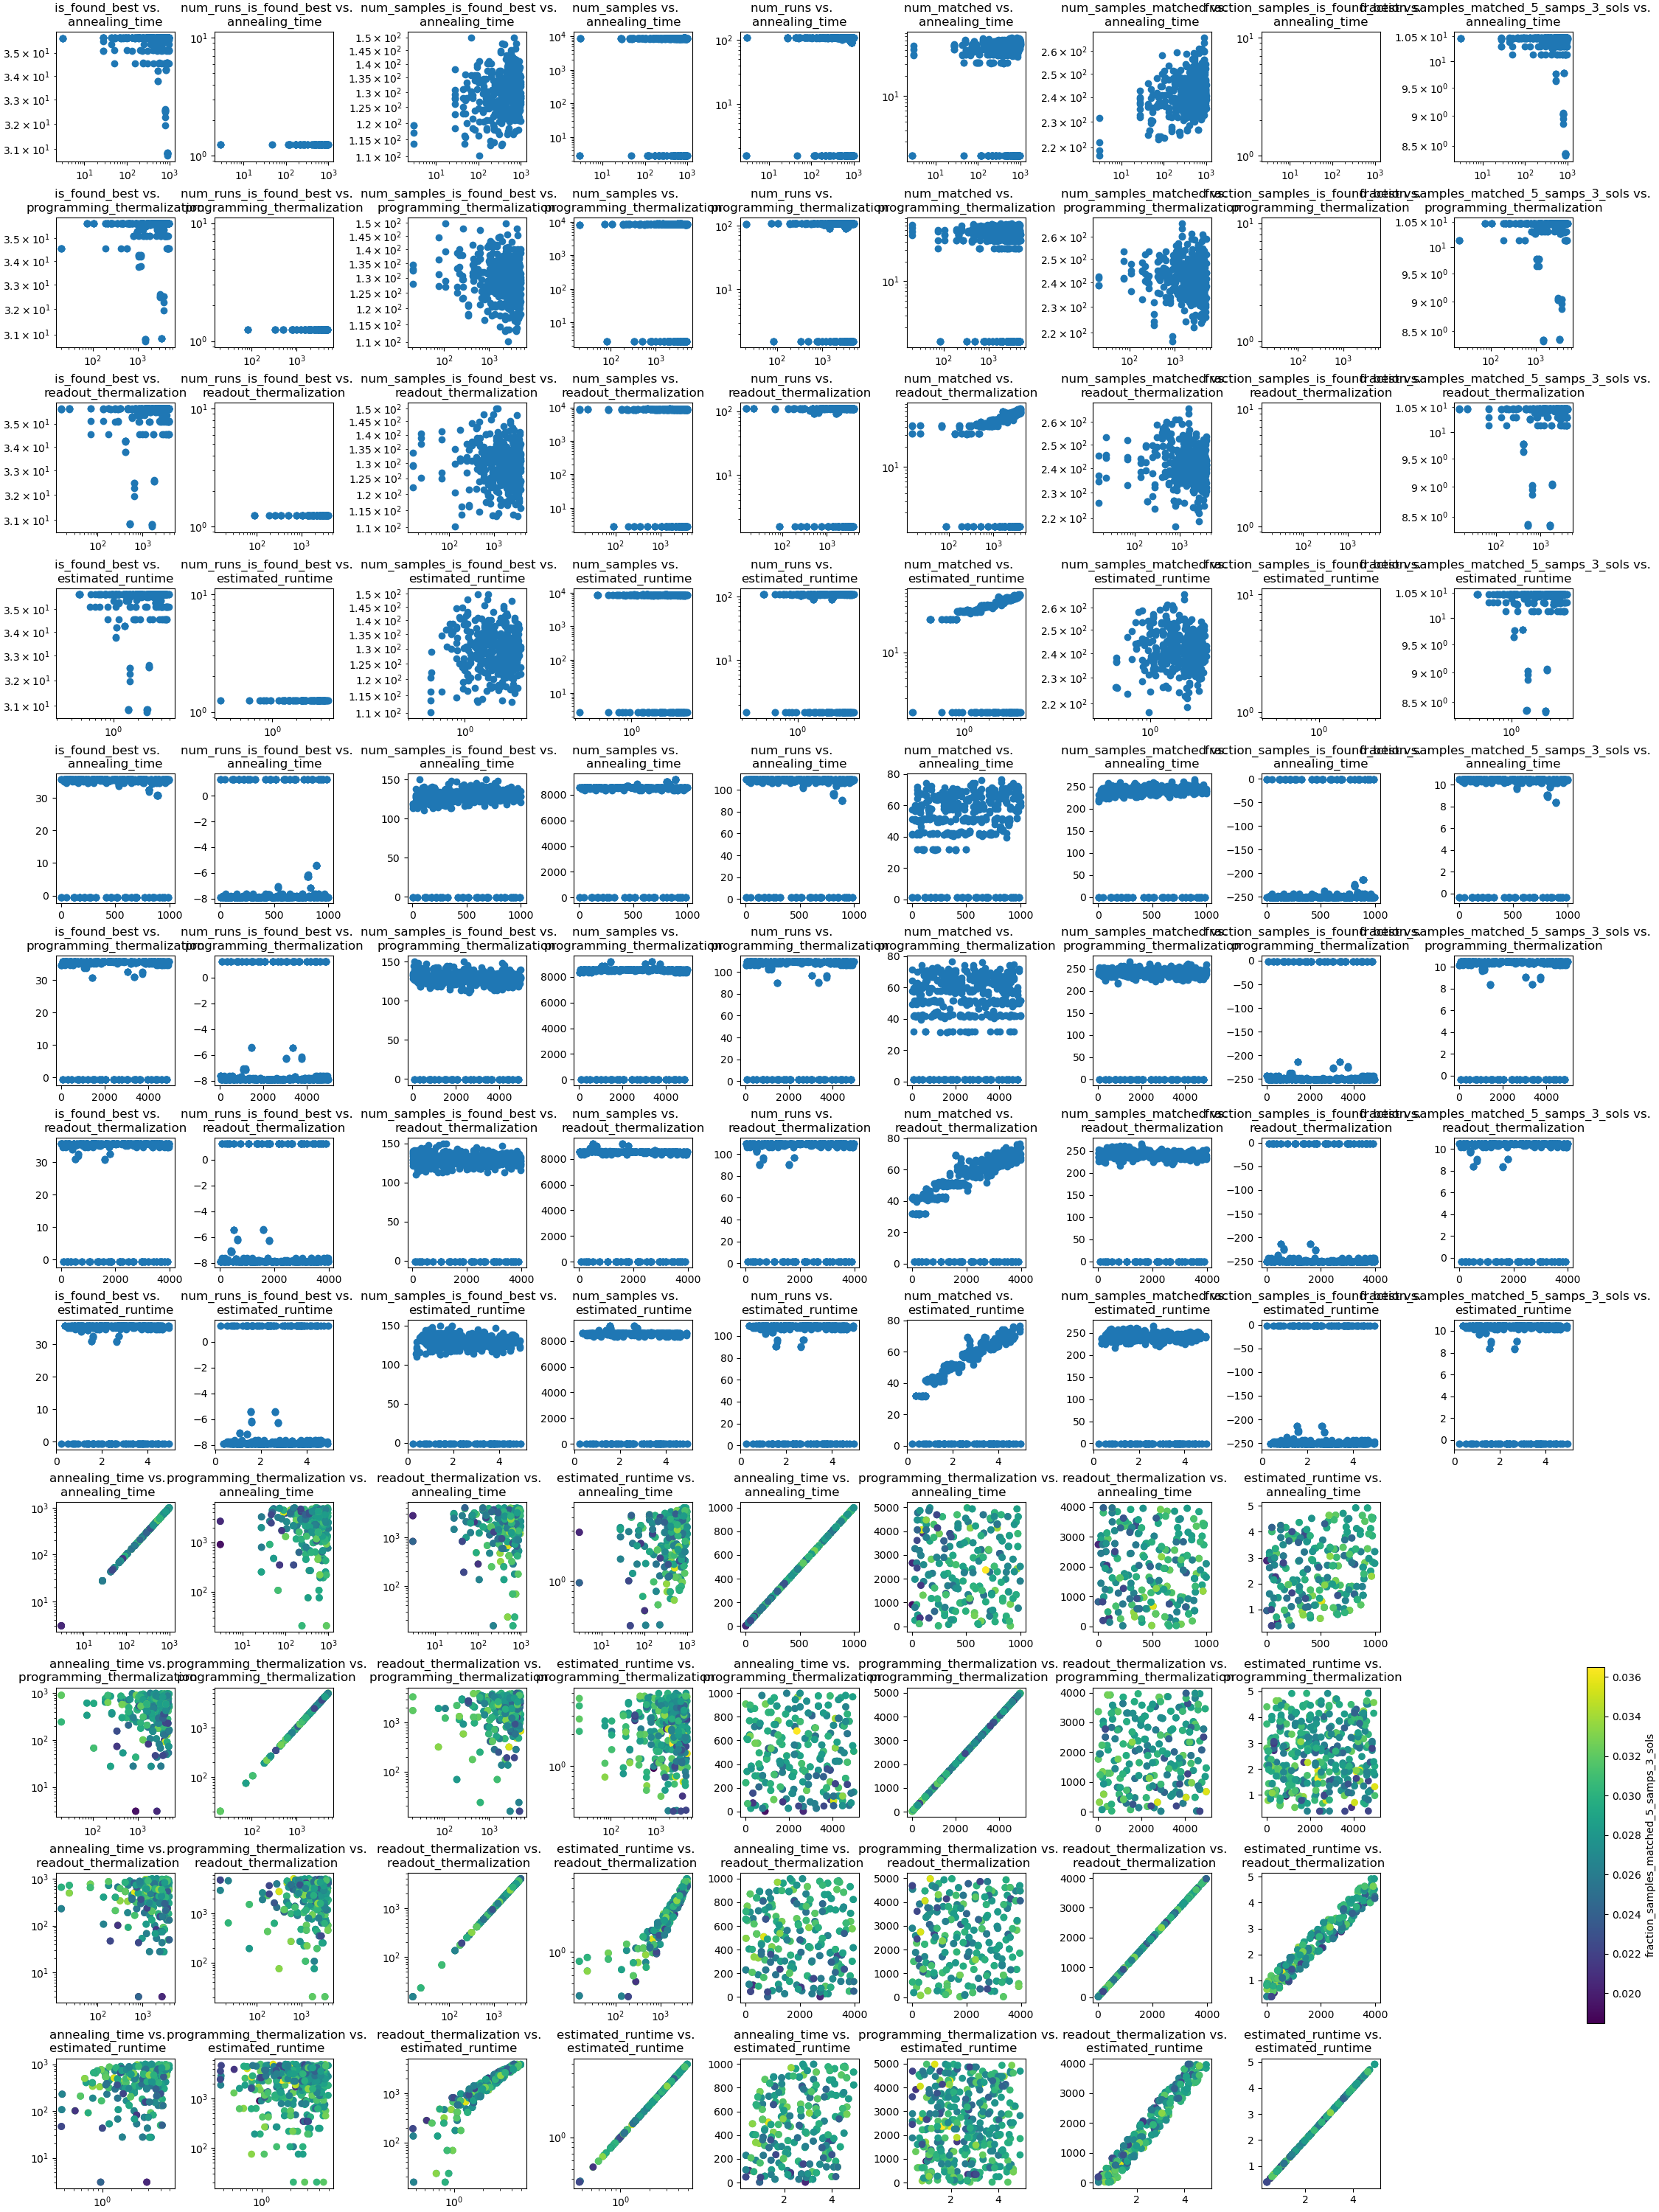

In [62]:
print(results_names)
print(mean.shape)
print(colour_label)
print(dir_name_path_plots)
fig2, fig_pp1 = h5py_funcs.inspections.return_plots(study_name = study_name\
        , study_matched_started_ids = study_matched_started_ids\
        , gp_mean = mean, results_names = results_names, dict_info_read = dict_info_read\
        , sampler_array = sampler_array, colour_label = colour_label, dir_name_path_plots = dir_name_path_plots)

In [63]:
plt.close()

No such comm: 727e35ded354462f85c961916e794e94


In [64]:

fig_pp1.show()